# Cardiovascular Disease Classification Project




We have used Cardiovascular Disease dataset (https://www.kaggle.com/sulianova/cardiovascular-disease-dataset). Based on some health information of an individual our model will predict whether he has any cardiovascular disease or not.

##Data description
There are 3 types of input features:

*   Objective: factual information;
*   Examination: results of medical examination;
*   Subjective: information given by the patient.

Features:
*   Age | Objective Feature | age | int (days)
*   Height | Objective Feature | height | int (cm) |
*   Weight | Objective Feature | weight | float (kg) |
*   Gender | Objective Feature | gender | categorical code |
*   Systolic blood pressure | Examination Feature | ap_hi | int |
*   Diastolic blood pressure | Examination Feature | ap_lo | int |
*   Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |
*   Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |
*   Smoking | Subjective Feature | smoke | binary |
*   Alcohol intake | Subjective Feature | alco | binary |
*   Physical activity | Subjective Feature | active | binary |
*   Presence or absence of cardiovascular disease | Target Variable | cardio | binary |

## Imports

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
import cufflinks as cf
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
%matplotlib inline
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
# Suppressing Warnings
import warnings
warnings.filterwarnings('ignore')
init_notebook_mode(connected=True)


## Dataset reading

In [72]:
# Load Dataset
df = pd.read_csv("cardio_train.csv", sep=';')

df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [73]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id,70000.0,49972.419900,28851.302323,0.0,25006.75,50001.5,74889.25,99999.0
age,70000.0,19468.865814,2467.251667,10798.0,17664.00,19703.0,21327.00,23713.0
gender,70000.0,1.349571,0.476838,1.0,1.00,1.0,2.00,2.0
height,70000.0,164.359229,8.210126,55.0,159.00,165.0,170.00,250.0
weight,70000.0,74.205690,14.395757,10.0,65.00,72.0,82.00,200.0
ap_hi,70000.0,128.817286,154.011419,-150.0,120.00,120.0,140.00,16020.0
ap_lo,70000.0,96.630414,188.472530,-70.0,80.00,80.0,90.00,11000.0
cholesterol,70000.0,1.366871,0.680250,1.0,1.00,1.0,2.00,3.0
gluc,70000.0,1.226457,0.572270,1.0,1.00,1.0,1.00,3.0
smoke,70000.0,0.088129,0.283484,0.0,0.00,0.0,0.00,1.0


##Exploratory Data Analysis

In [74]:
# Check for duplicates 
print("{} rows are same".format(df.duplicated().sum()))
# Check for Missing values 
print(f"Missing values are present: {df.isnull().sum().any()}")
print(df.shape)

0 rows are same
Missing values are present: False
(70000, 13)


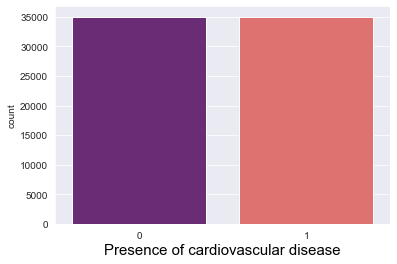

In [75]:
sns.set_style('darkgrid')
sns.countplot(df.cardio,palette='magma')
plt.xlabel('Presence of cardiovascular disease',fontdict={'fontsize': 15,'color':'black'},labelpad=3);

**Data is almost balanced**

---



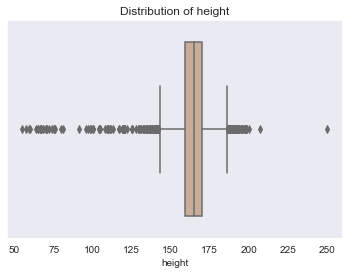

In [76]:
# Box plot for height
sns.set_style('dark')
sns.boxplot(df.height,palette='pink')
plt.title('Distribution of height');

**250 cm height is extremely rare cases**

---



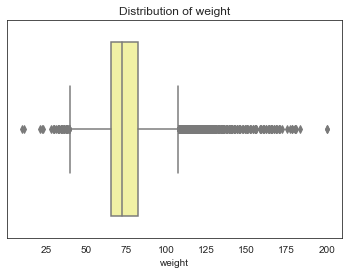

In [77]:
# Box plot for weight 
sns.set_style('white')
sns.boxplot(df.weight,palette='terrain')
plt.title('Distribution of weight');

**200 kg weight is extremely rare cases**

---



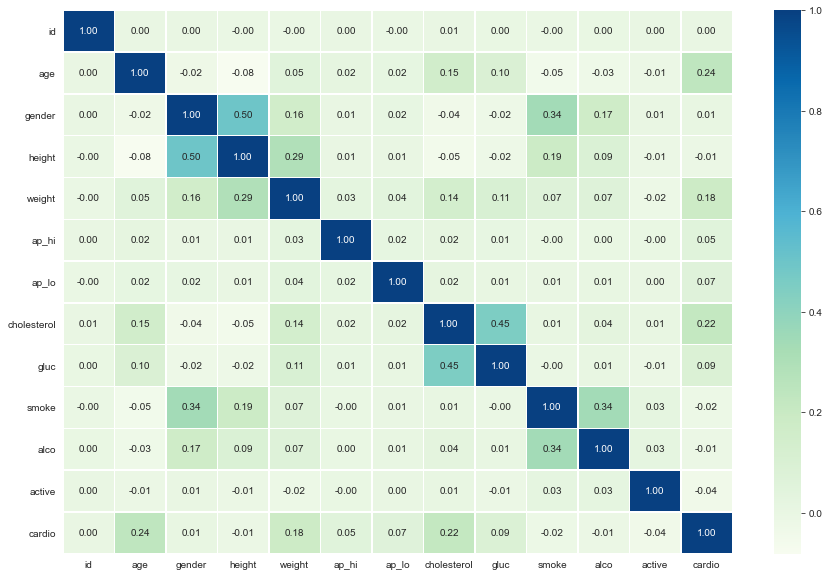

In [78]:
# Make a correlation matrix and plot it using seaborn
corr_matrix = df.corr()
fig, ax = plt.subplots(figsize = (15,10))
ax = sns.heatmap(
    corr_matrix, 
    annot = True, 
    linewidths = 0.5,
    fmt = '0.2f', 
    cmap = 'GnBu'
)

In [79]:
#plotting Correlation of features with target variable using plotly

init_notebook_mode(connected=True)
cf.go_offline()

print('Correlation of features with target variable')
df.corr()['cardio'].sort_values()[:-1].iplot(kind='barh');
plt.show()

Correlation of features with target variable


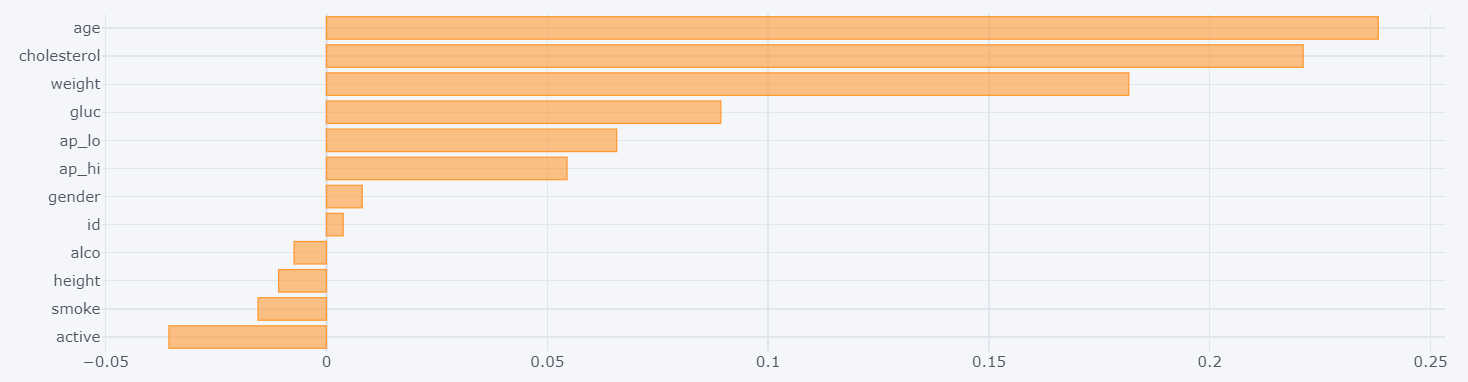

**The first 3 feature (Age, Cholestrol and weight) are most effective on cardiovascular disease (Age is the most effective)**


---



### Looking at the above information we see that:
- ID needs to be dropped.
- Age provided is in days. We will convert it to years
- Gender can be converted to binary
- ap_hi and ap_lo has negative numbers. This means that we have outliers so we need to remove them.
- Gluc and Cholestrol need to be converted to dummies
- There are many rare cases in height and weight features, so we can combine them in  BMI feature (get 1 feature from 2 features).

## Data cleaning & Preprocessing

In [80]:
data = df
# Drop ID
data = data.drop(['id'], axis=1)
# Convert Age to years 
# Check rounding
data['age'] = data['age']/365
# Merge Weight and Height into 1 feature: BMI
data['BMI'] = np.round(data['weight']/np.square(data['height']/100),1)
# Remove height and weight
data = data.drop(['weight', 'height'], axis=1)
data.head()
print(data.shape)

(70000, 11)


### Remove Outliers

In [81]:
# From BMI
data = data[(data["BMI"]>10) & (data["BMI"]<100)]
# From Blood Pressure
data = data[(data["ap_hi"]>20) & (data["ap_hi"]<250)]
data = data[(data["ap_lo"]>20) & (data["ap_lo"]<200)]

print(data.shape)


(68749, 11)


**We removed 1,251 row that means 1.7 % of data which is not too high**

---



### Convert categorical variable into indicator variables

In [82]:
# Convert numeric values in cholestrol to text
data['cholesterol'] = data['cholesterol'].map({ 1: 'normal', 2: 'aboveNormal', 3: 'wellAboveNormal'})
# Convert numeric values in glucose to text
data['gluc']=data['gluc'].map({ 1: 'normal', 2: 'aboveNormal', 3: 'wellAboveNormal'})
# Create Dummy Variable for Cholestrol and glucose
dummies = pd.get_dummies(data[['cholesterol','gluc']])

data = pd.concat([data,dummies],axis=1)

data.drop(['cholesterol','gluc'],axis=1,inplace=True)
data.head()

,age,gender,ap_hi,ap_lo,smoke,alco,active,cardio,BMI,cholesterol_aboveNormal,cholesterol_normal,cholesterol_wellAboveNormal,gluc_aboveNormal,gluc_normal,gluc_wellAboveNormal
0,50.391781,2,110,80,0,0,1,0,22.0,0,1,0,0,1,0
1,55.419178,1,140,90,0,0,1,1,34.9,0,0,1,0,1,0
2,51.663014,1,130,70,0,0,0,1,23.5,0,0,1,0,1,0
3,48.282192,2,150,100,0,0,1,1,28.7,0,1,0,0,1,0
4,47.873973,1,100,60,0,0,0,0,23.0,0,1,0,0,1,0


In [83]:
# Convert gender to binary values  --> 0 women, 1 men
data["gender"] = data["gender"] % 2
data.head()

,age,gender,ap_hi,ap_lo,smoke,alco,active,cardio,BMI,cholesterol_aboveNormal,cholesterol_normal,cholesterol_wellAboveNormal,gluc_aboveNormal,gluc_normal,gluc_wellAboveNormal
0,50.391781,0,110,80,0,0,1,0,22.0,0,1,0,0,1,0
1,55.419178,1,140,90,0,0,1,1,34.9,0,0,1,0,1,0
2,51.663014,1,130,70,0,0,0,1,23.5,0,0,1,0,1,0
3,48.282192,0,150,100,0,0,1,1,28.7,0,1,0,0,1,0
4,47.873973,1,100,60,0,0,0,0,23.0,0,1,0,0,1,0


### Scaling non-categorical data

In [84]:
# Standardization for non categorical features, concatenate with categorical

# Scaling function takes data and type of scaler and return scaled data
def Scaling_fn(dat, scaler):
  non_categorical = ['age', 'ap_hi', 'ap_lo', 'BMI']
  # Normalize non-categorical data only 
  dat[non_categorical] = scaler.fit_transform(dat[non_categorical])
  return dat

### PCA

In [85]:
# Principal component analysis 
def pca_fn(components, dat):
  pca = PCA(n_components = components)
  pca.fit(dat)
  pca_samples = pca.transform(dat)
  return pca_samples

###Data correlation after preprocessing

In [86]:
print('Correlation of features with target variable')
data.corr()['cardio'].sort_values()[:-1].iplot(kind='barh');
plt.draw()

Correlation of features with target variable


<Figure size 432x288 with 0 Axes>

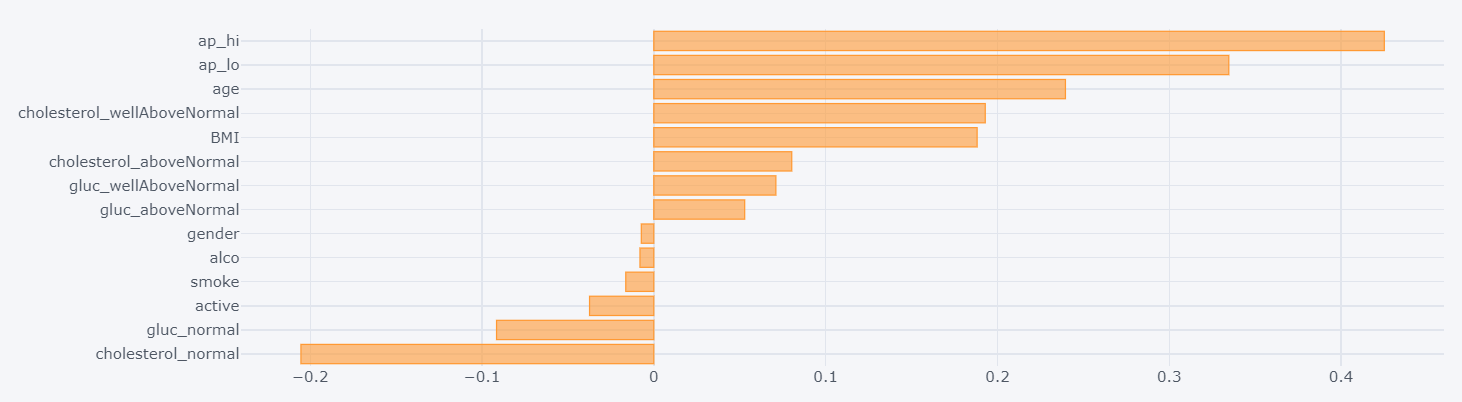

## Training

### Train-Test Split

In [87]:
# Fetch Target varaible
target = data['cardio']
data_copy = data
# Feature variables 
data = data.drop(['cardio'], axis=1)


In [88]:
# Split the data
# Split function takes features and target fata and return X_train, X_test, y_train, y_test data
def split_data(xData, yData):
  X_train, X_test, y_train, y_test = train_test_split(xData, yData, test_size=0.25, random_state=0)
  return X_train, X_test, y_train, y_test

### Classification

In [89]:
# classification_models function takes train and test data and return accuracies of the models
def classification_models(X_train, X_test, y_train, y_test):
  # define classification models
  classifiers = {
      'Logistic Regression' : LogisticRegression(),
      'Decision Tree' : DecisionTreeClassifier(),
      'Random Forest' : RandomForestClassifier(),
      'Support Vector Machines' : LinearSVC(),
      'K-nearest Neighbors' : KNeighborsClassifier(),
      'Naive Bayes': GaussianNB()
  }
  results=pd.DataFrame(columns=['Accuracy in %','F1-score'])
  #  loop through classifications models -> train each model, fit the model  then  record accuracy 
  for method,func in classifiers.items():
      func.fit(X_train,y_train)
      pred = func.predict(X_test)
      results.loc[method]= [100*np.round(accuracy_score(y_test,pred),decimals=4),np.round(f1_score(y_test,pred),2)]
  return results

In [104]:
# Classification without PCA or data scaling
X_train, X_test, y_train, y_test = split_data(data, target)
print(classification_models(X_train, X_test, y_train, y_test))

                         Accuracy in %  F1-score
Logistic Regression              71.82      0.70
Decision Tree                    62.72      0.63
Random Forest                    69.93      0.70
Support Vector Machines          52.01      0.68
K-nearest Neighbors              68.80      0.68
Naive Bayes                      66.92      0.63


## Enhancements

### Preprocissing enhancements

#### Classification models without data scaling to choose PCA number of components

In [105]:
target_copy = data_copy['cardio']
data_copy_1 = data_copy.drop(['cardio'], axis=1)
n_components_arr = [0.95, 2, 5, 7]
for i in n_components_arr:
  print ("Number of components = ", i)
  samples = pca_fn(i, data_copy_1)
  X_train, X_test, y_train, y_test = split_data(samples, target_copy)
  print(classification_models(X_train, X_test, y_train, y_test))

Number of components =  0.95
                         Accuracy in %  F1-score
Logistic Regression              71.39      0.70
Decision Tree                    62.34      0.62
Random Forest                    67.62      0.67
Support Vector Machines          71.49      0.70
K-nearest Neighbors              67.81      0.68
Naive Bayes                      69.46      0.65
Number of components =  2
                         Accuracy in %  F1-score
Logistic Regression              71.24      0.69
Decision Tree                    62.83      0.63
Random Forest                    68.13      0.68
Support Vector Machines          71.29      0.69
K-nearest Neighbors              68.35      0.68
Naive Bayes                      70.30      0.66
Number of components =  5
                         Accuracy in %  F1-score
Logistic Regression              71.50      0.70
Decision Tree                    63.22      0.63
Random Forest                    69.33      0.69
Support Vector Machines          68.1

**The non-normalized data showed the highest accuracy in almost all models with PCA n_components = 5**

---



#### Scale data using MinMaxscaler, StandardScaler, and Normalizer with PCA component = 5

In [106]:
n_components = 5
scaler_target = data_copy['cardio']
data_copy_2 = data_copy.drop(['cardio'], axis=1)
# Define types of sclaers to choose one of them 
scaler = {
      'MinMaxScaler': MinMaxScaler(),
      'StandardScaler': StandardScaler(),
      'Normalization' : Normalizer()
  }
  # Train all models on each type of scalars to get highest Accuracy
for method, func in scaler.items():  
  print ("Scaler type: ", method)
  data_scaler = data_copy_2
  data_scaled = Scaling_fn(data_scaler, func)
  trans_data = pca_fn(n_components, data_scaled)
  X_train, X_test, y_train, y_test = split_data(trans_data, scaler_target)
  print(classification_models(X_train, X_test, y_train, y_test))

Scaler type:  MinMaxScaler
                         Accuracy in %  F1-score
Logistic Regression              58.84      0.46
Decision Tree                    63.01      0.63
Random Forest                    69.22      0.69
Support Vector Machines          58.90      0.46
K-nearest Neighbors              69.49      0.69
Naive Bayes                      58.94      0.49
Scaler type:  StandardScaler
                         Accuracy in %  F1-score
Logistic Regression              71.43      0.70
Decision Tree                    62.85      0.63
Random Forest                    69.19      0.69
Support Vector Machines          71.29      0.69
K-nearest Neighbors              68.37      0.68
Naive Bayes                      69.47      0.67
Scaler type:  Normalization
                         Accuracy in %  F1-score
Logistic Regression              71.61      0.71
Decision Tree                    62.88      0.63
Random Forest                    69.06      0.69
Support Vector Machines          7

**From previous results, we can see that accuracies of 'StandardScaler' and 'Normalization' are too close so we will choose 'StandardScaler'** 

---



#### Accuracies with PCA components = 5 and scaled data


In [107]:
# Classification without PCA or data scaling 
X_train, X_test, y_train, y_test = split_data(data, target)
print("Accuracies before Preprocissing enhancements")
print(classification_models(X_train, X_test, y_train, y_test))


n_components = 5
scaler = StandardScaler()
data_copy_3 = data_copy.drop(['cardio'], axis=1)
scaled_data = Scaling_fn(data_copy_3, scaler)
Transformed_data = pca_fn(n_components, scaled_data)
X_train, X_test, y_train, y_test = split_data(Transformed_data, target_copy)
print("Accuracies after Preprocissing enhancements")
print(classification_models(X_train, X_test, y_train, y_test))

Accuracies before Preprocissing enhancements
                         Accuracy in %  F1-score
Logistic Regression              71.82      0.70
Decision Tree                    62.81      0.63
Random Forest                    69.91      0.70
Support Vector Machines          51.89      0.10
K-nearest Neighbors              68.80      0.68
Naive Bayes                      66.92      0.63
Accuracies after Preprocissing enhancements
                         Accuracy in %  F1-score
Logistic Regression              71.43      0.70
Decision Tree                    62.77      0.63
Random Forest                    69.27      0.69
Support Vector Machines          71.29      0.69
K-nearest Neighbors              68.37      0.68
Naive Bayes                      69.47      0.67


**We found that there is very small reduction in accuracies of Logistic Regression, Random Forest and Random Forest but there is great enhancement in SVM and relatively high enhancement in Naive Bayes. So that is acceptable.**


---



### Enhancements by changing hyperparameters 

#### KNN enhancement

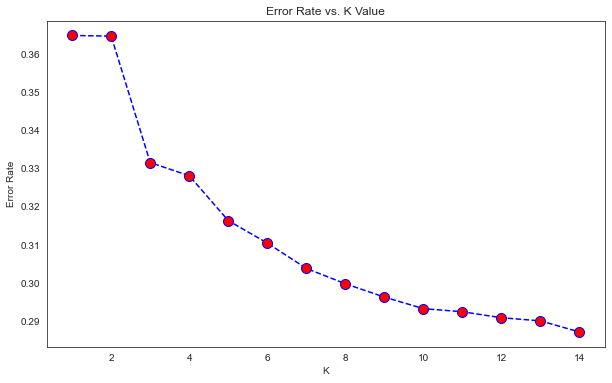

In [108]:
# Choosing proper K by elbow method
K = range(1,15)
error_rate = []
for i in K:
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

plt.figure(figsize=(10,6))
plt.plot(range(1,15),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate');

In [109]:
knn = KNeighborsClassifier(n_neighbors=14)
knn.fit(X_train,y_train)
knn_pred = knn.predict(X_test)
test_accuracy = accuracy_score(y_test, knn_pred)
print("Testing Accuracy", test_accuracy)

Testing Accuracy 0.7128810798231324


**Accuracy was 68.37, with k = 14 -> Accuracy = 71.28**

---



#### Tree enhancement

In [110]:

dep = np.arange(1,9)
param_grid = {'max_depth' : dep}

# Instantiate a decision tree classifier: clf
clf = DecisionTreeClassifier()

# Instantiate the GridSearchCV object: clf_cv
clf_cv = GridSearchCV(clf, param_grid=param_grid, cv=5)

# Fit it to the data
clf_cv.fit(X_train,y_train)

# Print the tuned parameter and score
print("Tuned Decision Tree Parameters: {}".format(clf_cv.best_params_))
print("Best score is {}".format(clf_cv.best_score_))

Tuned Decision Tree Parameters: {'max_depth': 5}
Best score is 0.7245980466179716


**Decision Tree Accuracy was 62.77, with max depth = 5 -> Accuracy = 72.45%**


---



#### Random Forest enhancement

In [111]:
# use GridSearchCV to get best parameters

param_grid = {'max_depth': [80, 90],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4],
    'min_samples_split': [8, 10],
    'n_estimators': [100, 200]}
# Instantiate the GridSearchCV object: clf_cv
grid=GridSearchCV(RandomForestClassifier(),param_grid,verbose=1)
# Train the model
grid.fit(X_train,y_train)
# get best parameters
grid.best_params_


Fitting 5 folds for each of 32 candidates, totalling 160 fits


{'max_depth': 90,
 'max_features': 2,
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 100}

**Note it takes 40 min to Run

In [112]:
# Test the model and get its accuracy  
grid_pred = grid.predict(X_test)
# print(classification_report(y_test,grid_pred))
test_accuracy = accuracy_score(y_test, grid_pred)
test_accuracy

0.7107284151733768

**Accuracy was 69.03, with best parameters:'max_depth': 90, 'max_features': 2, 
'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100 -> Accuracy = 71.07%**

---



## Conclusion 


### Accuracies:
Logistic Regression ........ 71.43%         
Decision Tree ................... 72.45%   
Random Forest ................ 71.07%     
Support Vector Machines  71.29%     
K-nearest Neighbors ....... 71.28%     
Naive Bayes ..................... 69.47%

### Decision Tree is the highest accuarcy 72.45%

---

